In [1]:
import json
import numpy as np

In [2]:
friend_data = np.genfromtxt('grupee_data/friends.csv', delimiter=',', dtype=int)
friendships = [[] for _ in range(np.max(friend_data[:,0])+1)]

for id in set(friend_data[:,0]):
    friendships[id] = [id, friend_data[friend_data[:, 0] == id, 1]]

with open('grupee_data/preferences.json') as file:
    preferences = json.load(file)

with open('grupee_data/n_concerts.txt') as file:
    n_concerts = file.read().split('\n')[1:-1]
    concerts = np.array([(x.split(':')[0], x.split(':')[1]) for x in n_concerts])
    file.close()

In [3]:
friendship_matrix = np.empty((len(friendships), len(friendships)), dtype=int)

for i, id in enumerate(friendships):
    row = np.zeros(len(friendships))
    if id:
        row[id[1]] = 1
        friendship_matrix[i] = row
    else:
        friendship_matrix[i] = row
        
friendship_matrix = friendship_matrix + friendship_matrix.T - np.diag(friendship_matrix.diagonal())

<h3>Define likelihoods</h3>

In [4]:
visit_concerts = {
    'none': .002,
    'one': 0.018,
    'both': 0.393,
}

In [5]:
equalPrefs = []

for ind in range(len(preferences['0'])):
    genrePref = []
    for (id, row) in zip(preferences.keys(), preferences.values()):
        if row[ind] == '1': genrePref.append(int(id))
    equalPrefs.append(genrePref)

***
<h2>Start with Processing</h2>

<h3>Laplacian Matrix</h3>

In [6]:
degreeMat = np.diag(np.sum(friendship_matrix, axis=1))
laplacian = degreeMat - friendship_matrix

degrees = np.empty((len(friendships), 2))

for id in range(len(friendships)):
    degrees[id] = (id, laplacian[id][id])

print(f'12% of {len(friendships)}: {len(friendships) * .12}')
sortedDegrees = sorted(degrees, key=lambda tup: tup[1])
mostInfluential = np.array(sortedDegrees[len(friendships)-round(len(friendships) * .12):], dtype=int)
#np.savetxt('a_team_5.txt', np.array(list(reversed(mostInfluential[:,0]))), delimiter='\n', fmt='%i')

12% of 8311: 997.3199999999999


<h3>Some other model...<h3>

In [ ]:
!pip install networkx

In [6]:
import networkx as nx

graph = nx.Graph()

graph.add_nodes_from(range(len(friendship_matrix)))

for id, row in enumerate(friendship_matrix):
    edges = [(id, x) for x in np.where(row == 1)[0]]
    myPref = [i for i, x in enumerate(preferences[f'{id}']) if x == '1']
    weights = np.zeros((len(edges), 84))
    for friend in edges:
        weight = np.zeros(84)
        weight.fill(visit_concerts['none'])
        friendPref = [i for i, x in enumerate(preferences[f'{friend[1]}']) if x == '1']
        
        common_interest = set(myPref) & set(friendPref)
        my_exclusive = set(myPref) - set(friendPref)
        friend_exclusive = set(friendPref) - set(myPref)
        
        weight[list(common_interest)] = visit_concerts['both']
        weight[list(my_exclusive)] = visit_concerts['one']
        weight[list(friend_exclusive)] = visit_concerts['one']
    
    graph.add_edges_from(edges, weight=weight)

In [8]:
print(graph.edges(1))

[(1, 0), (1, np.int64(11)), (1, np.int64(14)), (1, np.int64(28)), (1, np.int64(29)), (1, np.int64(30)), (1, np.int64(31)), (1, np.int64(32)), (1, np.int64(33)), (1, np.int64(34)), (1, np.int64(35)), (1, np.int64(36)), (1, np.int64(37)), (1, np.int64(38)), (1, np.int64(39)), (1, np.int64(40))]


In [7]:
import random
random.seed(42)
genres = range(84)

# create array to keep track of how many concerts each node (person) visits
visitation_rates = np.zeros(graph.number_of_nodes())

for genre in genres:
    for i in range(int(concerts[:,1][genre])):

        # track nodes (people) that already attended a concert
        visited = np.array([False for _ in range(graph.number_of_nodes())])

        for node in graph.nodes():
            edges = graph.edges(node)

            for edge in edges:
                if visited[edge[0]] or visited[edge[1]]: 
                    continue
                
                # set visit to true if random value is smaller than probability of concert attendance for current genre
                visit = random.random() < graph[edge[0]][edge[1]]['weight'][genre]
                if visit:
                    visitation_rates[[edge[0], edge[1]]] += 1
                    visited[[edge[0], edge[1]]] = True
                    break

In [8]:
test = [int(x) for x in concerts[:,1]]
print("No. of concerts:", sum(test))
print("Max visits:", max(visitation_rates))
print("Who visits max:", np.where(visitation_rates == max(visitation_rates))[0])
print("How many visit any concert:", len(np.where(visitation_rates > 0)[0]))

topTwelve = np.argsort(visitation_rates)[-997:]
print("Top twelve percent:", sorted(topTwelve))
# np.savetxt('b_team_5.txt', topTwelve, delimiter='\n', fmt='%i')

No. of concerts: 925
Max visits: 627.0
Who visits max: [108]
How many visit any concert: 8309
Top twelve percent: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(11), np.int64(13), np.int64(14), np.int64(17), np.int64(18), np.int64(20), np.int64(23), np.int64(24), np.int64(28), np.int64(30), np.int64(31), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(43), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(55), np.int64(56), np.int64(57), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(64), np.int64(65), np.int64(68), np.int64(69), np.int64(72), np.int64(73), np.int64(74), np.int64(77), np.int64(79), np.int64(80), np.int64(81), np.int64(82), np.int64(83), np.int64(86), np.int64(87), np.int64(88), np.int64(90), np.int64(93), np.int64(94), np.int64(96), np.int64(101), np.int64(102), np.int64(103), np.int64

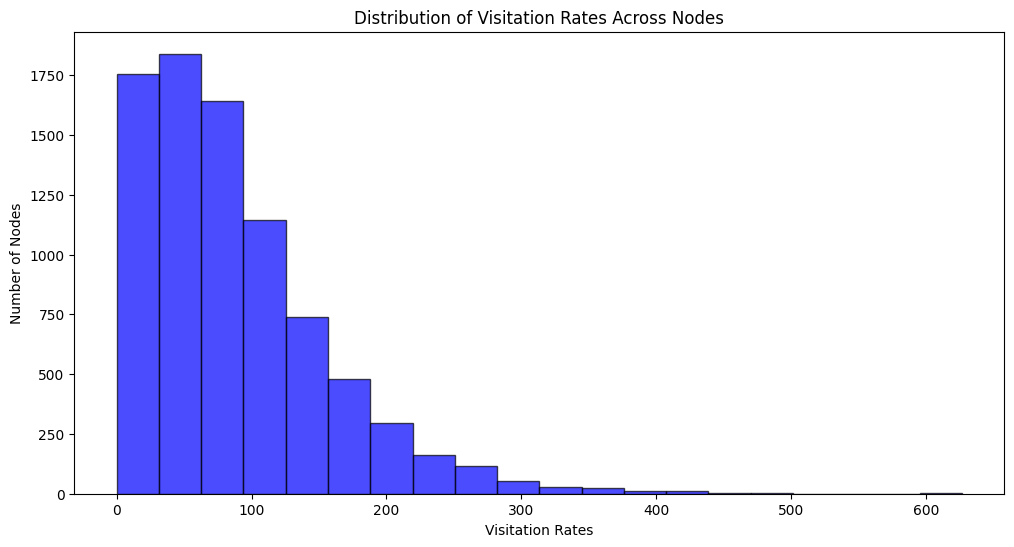

627.0


In [9]:
import matplotlib.pyplot as plt

# histogram of visitation rates
plt.figure(figsize=(12, 6))
plt.hist(visitation_rates, bins=20, color="blue", alpha=0.7, edgecolor="black")
#plt.axvline(max(visitation_rates), color="red", linestyle="--", label="Max Visits")
plt.xlabel("Visitation Rates")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Visitation Rates Across Nodes")
plt.show()

print(max(visitation_rates))

In [10]:
import networkx as nx

# compute scalar weights (average weight across all genres)
for u, v, data in graph.edges(data=True):
    data['scalar_weight'] = np.mean(data['weight'])

pos = nx.spring_layout(graph, seed=42, weight="'scalar_weight'") 

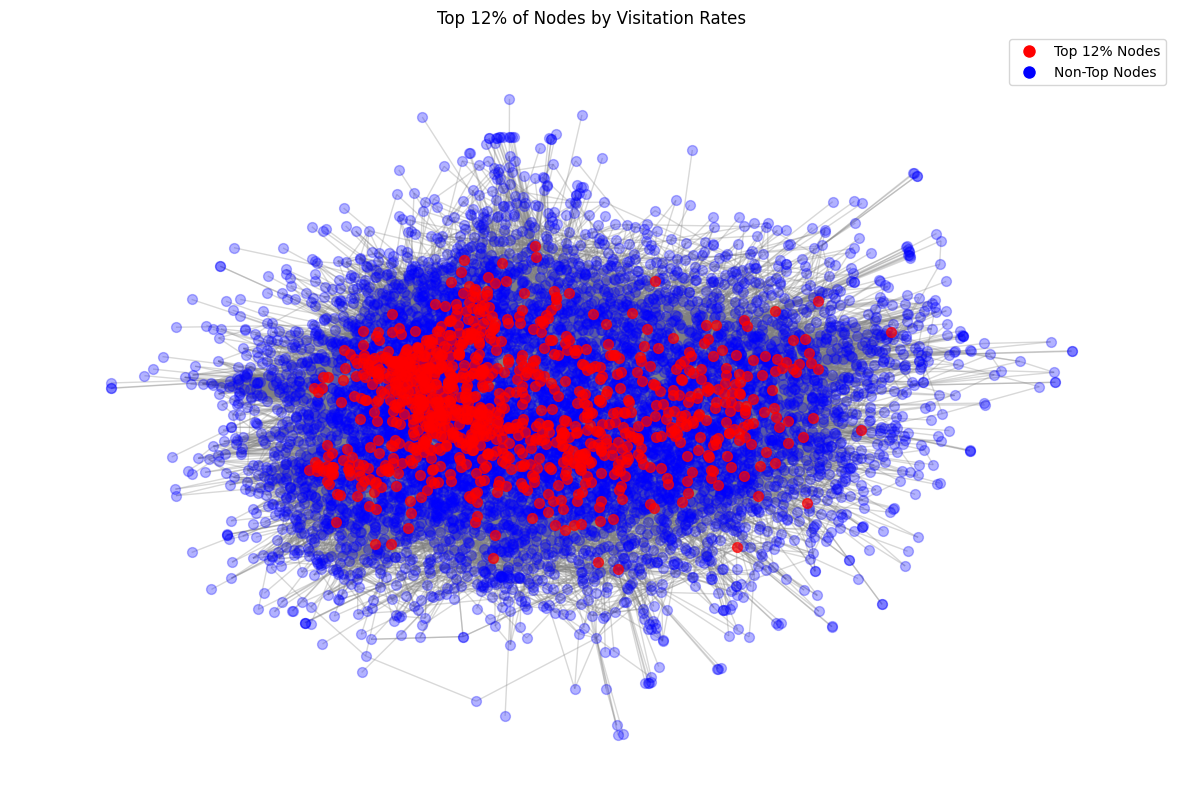

In [17]:
import matplotlib.lines as mlines

# Color nodes based on whether they are in the top 12%
# node_colors = ["red" if node in topTwelve else "blue" for node in graph.nodes()]
# node_sizes = [100 if node in topTwelve else 50 for node in graph.nodes()]

# plt.figure(figsize=(15, 10))
# nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color="gray")
# nx.draw_networkx_nodes(
#     graph,
#     pos,
#     node_color=node_colors,
#     node_size=node_sizes,
#     alpha=0.5,
# )

# plt.title(f"Top 12% of Nodes by Visitation Rates")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(15, 10))

nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color="gray")

non_top_nodes = [node for node in graph.nodes() if node not in topTwelve]
nx.draw_networkx_nodes(
    graph,
    pos,
    nodelist=non_top_nodes,
    node_color="blue",
    node_size=50,
    alpha=0.3,
)

top_nodes = [node for node in graph.nodes() if node in topTwelve]
nx.draw_networkx_nodes(
    graph,
    pos,
    nodelist=top_nodes,
    node_color="red",
    node_size=50,
    alpha=0.7,
)


legend_top = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Top 12% Nodes')
legend_non_top = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Non-Top Nodes')

plt.legend(handles=[legend_top, legend_non_top], loc='upper right')

plt.title(f"Top 12% of Nodes by Visitation Rates")
plt.axis("off")
plt.show()


# Spectral Clustering

using Laplacian eigenvalues

In [18]:
import networkx as nx

graph = nx.Graph()
graph.add_nodes_from(range(len(friendship_matrix)))

for id, row in enumerate(friendship_matrix):
    edges = [(id, x) for x in np.where(row == 1)[0]]
    myPref = [i for i, x in enumerate(preferences[f'{id}']) if x == '1']

    for friend in edges:
        friendPref = [i for i, x in enumerate(preferences[f'{friend[1]}']) if x == '1']
        
        common_interest = set(myPref) & set(friendPref)
        my_exclusive = set(myPref) - set(friendPref)
        friend_exclusive = set(friendPref) - set(myPref)
        
        # compute weight based on shared preferences
        weight = (len(common_interest) * visit_concerts['both'] +
                  len(my_exclusive) * visit_concerts['one'] +
                  len(friend_exclusive) * visit_concerts['one']) 
        
        # add edge with the weight
        graph.add_edge(id, friend[1], weight=weight)


In [19]:
# compute the normalized Laplacian
laplacian = nx.normalized_laplacian_matrix(graph).astype(float)
eigenvalues, eigenvectors = np.linalg.eigh(laplacian.toarray())

print("Laplacian Eigenvalues:", eigenvalues)

Laplacian Eigenvalues: [-7.31877171e-16  8.11702747e-02  8.70049292e-02 ...  1.80264205e+00
  1.85785639e+00  1.87560290e+00]


Option 1: Eigenvector Centrality (measuring influence in graph)

In [20]:
centrality = nx.eigenvector_centrality_numpy(graph, weight="weight")

# sort nodes based on centrality and select top 12%
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
top_12_percent = [node for node, _ in top_nodes[:int(len(graph.nodes()) * 0.12)]]

print(f"Top 12% of nodes to vaccinate based on centrality: {top_12_percent}")
print(len(top_12_percent))

Top 12% of nodes to vaccinate based on centrality: [694, 4024, 4011, 4017, 4013, 4014, 4022, 4019, 3999, 5254, 4002, 4027, 5192, 4006, 1886, 787, 3427, 1883, 2610, 311, 5264, 4008, 4016, 3548, 5250, 5277, 5271, 5181, 5179, 4015, 3543, 4023, 3550, 1877, 3997, 6378, 5251, 1923, 5188, 855, 2871, 4007, 5257, 3498, 5269, 391, 5150, 1980, 5279, 4009, 1879, 5272, 5346, 4018, 4001, 1904, 3998, 3216, 783, 2788, 4010, 366, 443, 5384, 5196, 1931, 5241, 5255, 3331, 3812, 4791, 1933, 5274, 4005, 1316, 4004, 4021, 5276, 837, 5182, 2225, 1309, 5184, 5314, 1974, 2471, 395, 4026, 5175, 1828, 1880, 1065, 6080, 5260, 4003, 835, 5380, 5149, 312, 4810, 5330, 5899, 3578, 5180, 1311, 838, 4811, 1518, 1362, 1687, 5214, 108, 2654, 1927, 1903, 1947, 1807, 4012, 3757, 1905, 492, 5258, 446, 5386, 1889, 5278, 299, 852, 1538, 1210, 4062, 5337, 2629, 1197, 1315, 846, 3695, 5187, 5303, 279, 1924, 1937, 790, 3664, 2595, 1245, 1576, 2242, 46, 853, 5193, 5242, 1515, 5186, 3495, 7273, 4786, 444, 5189, 4020, 1715, 1932, 2

In [21]:
import networkx as nx

# compute scalar weights (average weight across all genres)
for u, v, data in graph.edges(data=True):
    data['scalar_weight'] = np.mean(data['weight'])

pos = nx.spring_layout(graph, seed=42, weight="'scalar_weight'") 

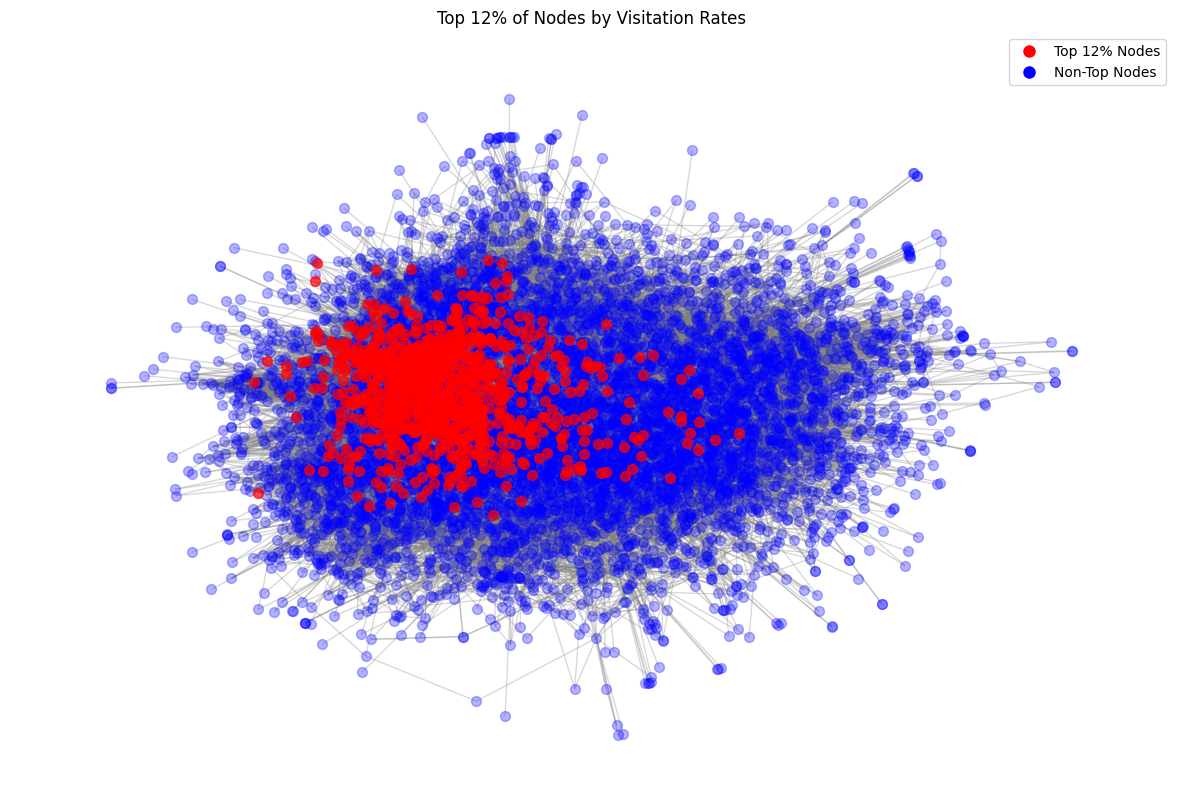

In [23]:
plt.figure(figsize=(15, 10))

nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color="gray")

non_top_nodes = [node for node in graph.nodes() if node not in top_12_percent]
nx.draw_networkx_nodes(
    graph,
    pos,
    nodelist=non_top_nodes,
    node_color="blue",
    node_size=50,
    alpha=0.3,
)

top_nodes = [node for node in graph.nodes() if node in top_12_percent]
nx.draw_networkx_nodes(
    graph,
    pos,
    nodelist=top_nodes,
    node_color="red",
    node_size=50,
    alpha=0.7,
)


legend_top = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Top 12% Nodes')
legend_non_top = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Non-Top Nodes')

plt.legend(handles=[legend_top, legend_non_top], loc='upper right')

plt.title(f"Top 12% of Nodes by Visitation Rates")
plt.axis("off")
plt.show()

Option 2: Clustering

In [ ]:
# convert edge weights to scalars (mean weight for each edge)
for u, v, data in graph.edges(data=True):
    data['weight'] = np.mean(data['weight'])

